# RNN, CNN으로 시계열데이터 다루기

# RNN

In [ ]:
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

(1001,)
<class 'numpy.ndarray'>


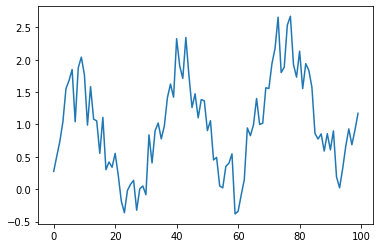

In [ ]:
# 시계열 데이터 (noisy sin)
#data = np.sin(2 * np.pi * 0.03 * np.arange(1001))   # sine 곡선
data = np.arange(1001)*0.01 + np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) # trend & noisy sine
print(data.shape)
print(type(data))
plt.plot(data[:100])


In [ ]:
# 1차원 배열의 시계열 데이터를 변환하여 학습용 배치 파일을 만든다. 입력값 = 1개, 출력값 = 1개
# return : xBatch - RNN 입력
#          yBatch - RNN 출력
#
# step = 3 인 경우의 예시
# xData = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
# 
# xBatch, yBatch는 3차원 텐서로 만든다. (-1, step=3, 1)
# xBatch = [[1]] [[2]] [[3]] [[4]] [[5]] [[6]] [[7]] --> 7 x 3 x 1
#          [[2]] [[3]] [[4]] [[5]] [[6]] [[7]] [[8]]
#          [[3]] [[4]] [[5]] [[6]] [[7]] [[8]] [[9]]
#
# yBatch =  [4]   [5]   [6]   [7]   [8]   [9]   [10] --> 7 x 1
#
# ex : xBatch[0] = [[3],[4],[5]],   yBatch[0] = [6]
#      3-step 짜리 LSTM에 3,4,5가 입력되면 6이 출력되도록 학습한다.

#2차원 데이터(여기선 1차원이지만...)를 받아 3차원 데이터 생성 (데이터수, 기간, feature 수)
# x는 과거 step 기간, y는 다음날 데이터
# 1칸씩 sliding 하도록 만듦
def createTrainData(xData, step, nFeature, nOutput, return_y_sequences=False):  
    m = np.arange(len(xData) - step)
    x, y = [], []
    for i in m:
        a = xData[i:(i+step)]
        x.append(a)
    xBatch = np.reshape(np.array(x), (len(m), step, nFeature))
    
    for i in m+1:
        a = xData[i:(i+step)]
        y.append(a) if return_y_sequences else y.append(a[-1])
    if return_y_sequences:  # 만약 RNN의 모든 h를 출력해서 이용한다면 그 출력과 정답셋 y가 동일 차원이 되어야 함. 당연히 lstm 위에 하나만 출력하는 lstm이 쌓인다면 여기가 실행되면 안됨
        yBatch = np.reshape(np.array(y), (len(m), step, nOutput))
    else:
        yBatch = np.reshape(np.array(y), (len(m), nOutput))
    
    return xBatch, yBatch


nFeature = 1
nOutput = 1  # 최종 OUTPUT 차원 
nStep = 20  # 과거 20기간의 흐름을 분석하자. 결국 이게 RNN 반복횟수가 됨
nHidden = 50  # 각 LSTM마다 나오는 OUTPUT 수

### 모델 생성

#### many_to_one LSTM

In [ ]:
xInput = Input(batch_shape=(None, nStep, 1))  # parameter 순서 지켜줘야 함
xLstm = LSTM(nHidden)(xInput)  # xInput의 nStep만큼 recursive 돌아감
#xLstm = LSTM(nHidden, activation="sigmoid", recurrent_activation="sigmoid")(xInput)  # tanh를 sigmoid로 바꿔보기(당연히 성능 안좋아짐). 기본값: activation="tanh", recurrent_activation="sigmoid"
xOutput = Dense(nOutput)(xLstm)  # 꼭 rnn 위에는 하나의 레이어 이상은 있어야 할듯. h의 역할과 output의 역할을 구분해주기 위해서?
model_m2o = Model(xInput, xOutput)

model_m2o.compile(loss='mse', optimizer=Adam(lr=0.01))
# tf.keras.utils.plot_model(model_m2o, 'model_m2o.png', show_shapes=True)
model_m2o.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


#### many_to_one LSTM + BILSTM
- BI 레이어에서는 forward 먼저 계산 하여 50크기 만들고 backward로 또 50크기를 출력 후,    
이 둘을 지정해준 merge_mode 방식으로 합침.   
(여기서는 concatenate해서 100차원을 출력함)
- many_to_many는 아니지만 lstm에서 다음 레이어인 BILSTM으로 모든 hidden을 전달해줘야 하기에 return_sequences=True을 사용했음에 주의
- 나머지는 many_to_one과 동일

In [ ]:
xInput = Input(batch_shape=(None, nStep, 1))  # parameter 순서 지켜줘야 함
xLstm1 = LSTM(nHidden, return_sequences=True)(xInput)
xLstm2 = Bidirectional(LSTM(nHidden), merge_mode='concat')(xLstm1)  # merge_mode='sum'
xOutput = Dense(nOutput)(xLstm2)  # 꼭 rnn 위에는 하나의 레이어 이상은 있어야 할듯. h의 역할과 output의 역할을 구분해주기 위해서?
model_m2o = Model(xInput, xOutput)

model_m2o.compile(loss='mse', optimizer=Adam(lr=0.01))
# tf.keras.utils.plot_model(model_m2o, 'model_m2o.png', show_shapes=True)
model_m2o.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 50,901
Trainable params: 50,901
Non-trainable params: 0
_________________________________________________________________


#### many_to_many LSTM
- LSTM뿐만 아니라 dense의 출력 또한 shape이 바뀐것 확인하기!!
- 수정1: 모델에서 LSTM(return_sequences=True), TimeDistributed(Dense(nOutput)) 추가.
    - 근데 lstm이 마지막 레이어가 아니라면 return_sequences=True라고 할지라도 TimeDistributed 안써도 됨
- 수정2: 데이터도 매 rnn마다 dense layer 태워서 y값과 비교해줘야 하므로, 데이터 y의 shape 또한 바꿔줘야함!

https://m.blog.naver.com/PostView.nhn?blogId=chunjein&logNo=221589624838&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:
xInput = Input(batch_shape=(None, nStep, 1))
xLstm = LSTM(nHidden, return_sequences=True)(xInput)  # hidden 다 쓰겠다
xOutput = TimeDistributed(Dense(nOutput))(xLstm)  # TimeDistributed: 각 스텝(time)마다 dense layer를 distribute해서 cost (오류)를 계산해서 하위 스텝으로 오류를 전파하여 각 weight를 업데이트하라. 
model_m2m = Model(xInput, xOutput)

model_m2m.compile(loss='mse', optimizer=Adam(lr=0.01))
# tf.keras.utils.plot_model(model_m2m, 'model_m2m.png', show_shapes=True)
model_m2m.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 1)             51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


![대체 텍스트](https://mblogthumb-phinf.pstatic.net/MjAxOTA3MTlfMTQ0/MDAxNTYzNDk5MDIwNjk0.Ko1jG4ematFNFGaS7dFJqJCKoyIVhLXsSLsUNWzadukg.laQainx0gqsofM7EmEi-A5POshd0OkX4yC4Ay0ZeOkwg.GIF.chunjein/2-1.gif?type=w2)

(981, 20, 1) (981, 1)


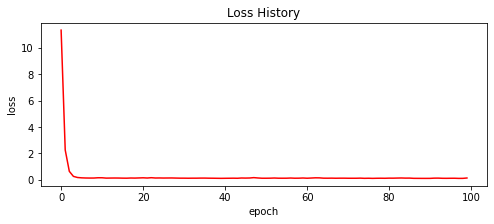

In [ ]:
# 학습 데이터를 생성한다.
is_m2o = True
if is_m2o:
    x, y = createTrainData(data, nStep, nFeature, nOutput)  # y shape가 (981, 1)
    model = model_m2o
else:
    x, y = createTrainData(data, nStep, nFeature, nOutput, return_y_sequences=True)  # y shape가 (981, 20, 1)
    model = model_m2m
print(x.shape, y.shape)

# 학습한다
h = model.fit(x, y, epochs=100, batch_size=100, shuffle=True, verbose=0)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
x[:2]

array([[[0.27460914],
        [0.50730057],
        [0.73696519],
        [1.04104618],
        [1.5524222 ],
        [1.67885738],
        [1.8486133 ],
        [1.04256269],
        [1.8770769 ],
        [2.04014426],
        [1.76701165],
        [0.99137867],
        [1.58351337],
        [1.08224432],
        [1.05564021],
        [0.55431837],
        [1.10987433],
        [0.30218778],
        [0.41976364],
        [0.33948734]],

       [[0.50730057],
        [0.73696519],
        [1.04104618],
        [1.5524222 ],
        [1.67885738],
        [1.8486133 ],
        [1.04256269],
        [1.8770769 ],
        [2.04014426],
        [1.76701165],
        [0.99137867],
        [1.58351337],
        [1.08224432],
        [1.05564021],
        [0.55431837],
        [1.10987433],
        [0.30218778],
        [0.41976364],
        [0.33948734],
        [0.55410717]]])

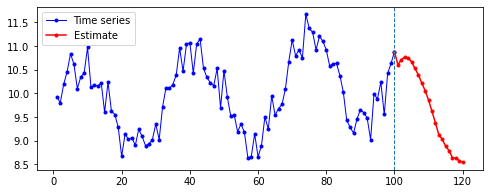

In [ ]:
# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
nFuture = 20
if len(data) > 100:
    lastData = np.copy(data[-100:])  # 원 데이터의 마지막 50개만 그려본다
else:
    lastData = np.copy(data)
dx = np.copy(lastData)
estimate = [dx[-1]]
for i in range(nFuture):
    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다
    px = dx[-nStep:].reshape(1, nStep, 1)
    
    # 다음 값을 예측한다.
    yHat = model.predict(px)[0][0]
        
    # 예측값을 저장해 둔다
    estimate.append(yHat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), yHat)


# 원 시계열과 예측된 시계열을 그린다
ax1 = np.arange(1, len(lastData) + 1)
ax2 = np.arange(len(lastData), len(lastData) + len(estimate))
plt.figure(figsize=(8, 3))
plt.plot(ax1, lastData, 'b-o', color='blue', markersize=3, label='Time series', linewidth=1)
plt.plot(ax2, estimate, 'b-o', color='red', markersize=3, label='Estimate')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()



In [ ]:
lastData.shape

(100,)

In [ ]:
y[:10]

array([[-0.30349134],
       [-0.40810395],
       [ 0.13833126],
       [-0.41271958],
       [-0.58180951],
       [-0.24924352],
       [-0.0918422 ],
       [ 0.15599108],
       [ 0.3856517 ],
       [ 0.22770505]])

# CNN

## CNN 계산 이해하기

In [ ]:
import tensorflow as tf
import numpy as np

nBatch, nHeight, nWidth, nChannel = (1, 5, 5, 1)                    # Image data shape
nFheight, nFwidth, nFchannel, nFcount = (2, 2, nChannel, 1)         # Convolution Filter shape
nPheight, nPwidth, nPchannel, nPcount = (2, 2, nChannel, nFcount)   # Pooling shape
nUheight, nUwidth, nUchannel, nUcount = (2, 2, nChannel, nFcount)   # Upsampling shape

X = np.arange(0.1, 2.6, 0.1).reshape(nBatch, nHeight, nWidth, nChannel)
F = np.round_(np.random.rand(4),2).reshape(nFheight, nFwidth, nFchannel, nFcount)
U = np.array(np.repeat(1,4), np.float32).reshape(nUheight, nUwidth, nUchannel, nUcount)

print("\nFeature image :")
print(X.reshape(nHeight, nWidth))

print("\nConvolution filter :")
print(F.reshape(nFheight, nFwidth))

print("\nUpsampling filter :")
print(U.reshape(nUheight, nUwidth))


Input image :
[[0.1 0.2 0.3 0.4 0.5]
 [0.6 0.7 0.8 0.9 1. ]
 [1.1 1.2 1.3 1.4 1.5]
 [1.6 1.7 1.8 1.9 2. ]
 [2.1 2.2 2.3 2.4 2.5]]

Convolution filter :
[[0.83 0.74]
 [0.05 0.87]]

Upsampling filter :
[[1. 1.]
 [1. 1.]]


An optional string from: "NHWC", "NCHW". Defaults to "NHWC"

In [ ]:
# tX = tf.constant(X, tf.float32)
# tF = tf.constant(F, tf.float32)
stride = 1
strides = [1, stride, stride, 1]

nBatch, nHeight, nWidth, nChannel 

# input, filter, stride, padding 등을 고려해서 output size 계산해보기
def conv_out_size(input, nFheight, stride, padding_type):
    nHeight, nWidth = input.shape[1],input.shape[2]

    if padding_type == 'VALID':
        padding = 0
        if (nHeight + padding*2 - nFheight) % stride != 0 or (nWidth + padding*2 - nFheight) % stride != 0:
            raise Exception('적절한 input, filter, stride, padding 크기의 조합이 아닙니다')

        oHeight = int((nHeight + padding*2 - nFheight)/stride) + 1
        oWidth = int((nWidth + padding*2 - nFwidth)/stride) + 1
    elif padding_type == 'SAME':
        oHeight, oWidth = nHeight, nWidth
    return oHeight, oWidth


oHeight_conv, oWidth_conv = conv_out_size(X, nFheight, stride, 'VALID')
Cl = tf.nn.conv2d(X, F, strides=strides, padding='VALID') # Convolution layer. VALID는 padding 안한다는것

oHeight_max_pool, oWidth_max_pool = conv_out_size(Cl, nPheight, stride, 'SAME')
Pl = tf.nn.max_pool(Cl, ksize=[1, nPheight, nPwidth, 1], strides=strides, padding='SAME')  # 출력크기가 이미지 크기대로 유지되도록 padding을 넣어준다

Ul = tf.nn.conv2d_transpose(Pl, U, output_shape=(1, nHeight, nWidth, 1), strides=strides, padding='VALID')

print("\nConvolution :")

print(Cl.numpy().reshape(oHeight_conv, oWidth_conv))    # padding = VALID가 적용되었음

print("\nPooling :")

print(Pl.numpy().reshape(oHeight_max_pool, oWidth_max_pool))      # padding = SAME이 적용되었음

print("\nUpSampling :")
print(Ul.numpy().reshape(nHeight, nWidth))


Convolution :
[[0.87  1.119 1.368 1.617]
 [2.115 2.364 2.613 2.862]
 [3.36  3.609 3.858 4.107]
 [4.605 4.854 5.103 5.352]]

Pooling :
[[2.364 2.613 2.862 2.862]
 [3.609 3.858 4.107 4.107]
 [4.854 5.103 5.352 5.352]
 [4.854 5.103 5.352 5.352]]

UpSampling :
[[ 2.364  4.977  5.475  5.724  2.862]
 [ 5.973 12.444 13.44  13.938  6.969]
 [ 8.463 17.424 18.42  18.918  9.459]
 [ 9.708 19.914 20.91  21.408 10.704]
 [ 4.854  9.957 10.455 10.704  5.352]]


## CNN- cov1D
- 1D convolution을 이용하여 noisy sine with trend 시계열을 예측한다
- [Convolution --> Max pooling] -> [Fulliy connected N/W]

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

# Batch data를 생성한다.
def createTrainData(xData, step, nFeature):
    m = np.arange(len(xData) - step)
    
    x = []
    y = []
    for i in m:
        a = xData[i:(i+step)]
        x.append(a)
    
    # Conv1D를 사용하기 위해 3차원 구조로 변환한다. (batch_size, steps, input_dim)
    xBatch = np.reshape(np.array(x), (len(m), step, nFeature))
    
    for i in m+1:
        a = xData[i:(i+step)][-1]
        y.append(a)
    yBatch = np.reshape(np.array(y), (len(m), 1))
    
    return xBatch, yBatch

# 시계열 데이터 (noisy sine with trend)
nStep = 20
nFeature = 1

data = np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) + np.arange(1001)*0.03 # noisy sine with trend
x, y = createTrainData(data, nStep, nFeature)
print(x.shape, y.shape)

(981, 20, 1) (981, 1)


In [ ]:
# Convolutional 1D 모델을 생성한다.
xInput = Input(batch_shape = (None, nStep, nFeature))

# 크기 8짜리가 h=20을 한 방향으로 1칸씩 이동하니 13, 이러한 필터가 30개. cov1d기 때문에 height 방향으로의 kernel_size만 채워주면 width쪽은 feature개수만큼 자동으로 바뀐다.
 # kernel_size*feature수 만큼 w 개수존재, 그리고 한개 b. 이 묶음이 30개 있음 -> 270개 parameters
xConv = Conv1D(filters=30, kernel_size=8, strides=1, padding = 'valid', activation='relu')(xInput) 

# 이건 학습대상이 아님. 빈 격자만 있어 max를 뽑아내는 역할만 함
# 앞 레이어에서 반환된 13*30에서 30은 filter별로 하나씩 결과를 붙인것. 따라서 maxpooling에서는 한 필터 내에서 height 4인 pool을 13개 라인을 따라 움직임 -> 10개 반환
xPool = MaxPooling1D(pool_size=4, strides=1, padding='valid')(xConv) 
xFlat = Flatten()(xPool)
xOutput = Dense(1, activation='linear')(xFlat)

model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer = optimizers.Adam(lr=0.001))
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 30)            270       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 30)            0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
4/4 [==============================] - 0s 5ms/step - loss: 229.1882
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 127.2002
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 48.8824
Epoch 4/100
4/4 [==============================] - 0s 5ms/step - loss: 7.9866
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 3.5577
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 13.0591
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 13.0955
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 5.9187
Epoch 9/100
4/4 [==============================] - 0s 5ms/step - loss: 1.5363
Epoch 10/100
4/4 [==============================] - 0s 5ms/step - loss: 1.4936
Epoch 11/100
4/4 [==============================] - 0s 5ms/step - loss: 2.5843
Epoch 12/100
4/4 [==============================] - 0s 5ms/step - loss: 2.5659
Epoch 13/100
4/4 [==============================] - 0s

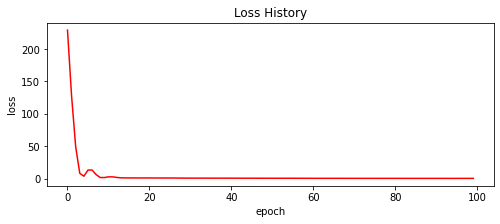

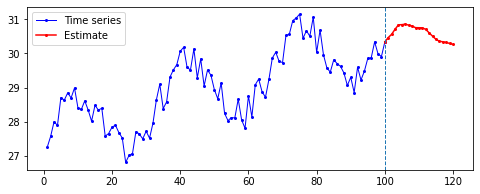

In [ ]:

# 모델을 학습한다.
h = model.fit(x, y, epochs = 100, batch_size = 300)

# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
nFuture = 20
if len(data) > 100:
    lastData = np.copy(data[-100:])  # 원 데이터의 마지막 150개만 그려본다
else:
    lastData = np.copy(data)
dx = np.copy(lastData)
estimate = [dx[-1]]
for i in range(nFuture):
    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다
    px = dx[-nStep:]
    px = np.reshape(px, (-1, nStep, nFeature))
    
    # 다음 값을 예측한다.
    yHat = model.predict(px)[0][0]
    
    # 예측값을 저장해 둔다
    estimate.append(yHat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), yHat)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 원 시계열과 예측된 시계열을 그린다
ax1 = np.arange(1, len(lastData) + 1)
ax2 = np.arange(len(lastData), len(lastData) + len(estimate))
plt.figure(figsize=(8, 3))
plt.plot(ax1, lastData, 'b-o', markersize=2, color='blue', label='Time series', linewidth=1)
plt.plot(ax2, estimate, 'b-o', markersize=2, color='red', label='Estimate')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()


## CNN-cov2D
- [Convolution --> Max pooling] -> [Convolution --> Max pooling] -> [Fulliy connected N/W]

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt

# 학습 데이터를 생성한다.
def createTrainData(xData, step):
    m = np.arange(len(xData) - step)
    np.random.shuffle(m)
    
    x = []
    y = []
    for i in m:
        a = xData[i:(i+step)]
        x.append(a)
    
    # Conv2D를 사용하기 위해 4차원 구조로 변환한다. (samples, rows, cols, channels)
    xBatch = np.reshape(np.array(x), (len(m), step, 1, 1))
    
    for i in m+1:
        a = xData[i:(i+step)][-1]
        y.append(a)
    yBatch = np.reshape(np.array(y), (len(m), 1))
    
    return xBatch, yBatch

# 시계열 데이터 (noisy sine with trend)
nStep = 20
nFeature = 1
nChannel = 1
data = np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001) + np.arange(1001)*0.03 # noisy sine with trend
x, y = createTrainData(data, nStep)


In [ ]:

# Convolutional 2D 모델을 생성한다. 2개의 Conv -> Pooling
# 1차원 시계열 데이터의 경우는 Conv1D가 적합하지만, 연습 차원에서 Conv2D를 적용해 본다.
xInput = Input(batch_shape = (None, nStep, nFeature, nChannel))
xConv1 = Conv2D(filters=30, kernel_size=(8,1), strides=1, padding = 'same', activation='relu')(xInput)
xPool1 = MaxPooling2D(pool_size=(2,1), strides=1, padding='valid')(xConv1)
xConv2 = Conv2D(filters=10, kernel_size=(8,1), strides=1, padding = 'same', activation='relu')(xPool1)
xPool2 = MaxPooling2D(pool_size=(2,1), strides=1, padding='valid')(xConv2)
xFlat = Flatten()(xPool2)
xOutput = Dense(1, activation='linear')(xFlat)

model = Model(xInput, xOutput)
model.compile(loss='mse', optimizer = optimizers.Adam(lr=0.001))
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 20, 1, 1)]        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 1, 30)         270       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 1, 30)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 1, 10)         2410      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 1, 10)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 180)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 181 

In [ ]:

# 모델을 학습한다.
h = model.fit(x, y, epochs = 100, batch_size = 300)

# 향후 20 기간 데이터를 예측한다. 향후 1 기간을 예측하고, 예측값을 다시 입력하여 2 기간을 예측한다.
# 이런 방식으로 20 기간까지 예측한다.
nFuture = 20
if len(data) > 100:
    lastData = np.copy(data[-100:])  # 원 데이터의 마지막 100개만 그려본다
else:
    lastData = np.copy(data)
dx = np.copy(lastData)
estimate = [dx[-1]]
for i in range(nFuture):
    # 마지막 nStep 만큼 입력데이로 다음 값을 예측한다
    px = dx[-nStep:]
    px = np.reshape(px, (-1, nStep, nFeature, nChannel))
    
    # 다음 값을 예측한다.
    yHat = model.predict(px)[0][0]
    
    # 예측값을 저장해 둔다
    estimate.append(yHat)
    
    # 이전 예측값을 포함하여 또 다음 값을 예측하기위해 예측한 값을 저장해 둔다
    dx = np.insert(dx, len(dx), yHat)

# Loss history를 그린다
plt.figure(figsize=(8, 3))
plt.plot(h.history['loss'], color='red')
plt.title("Loss History")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 원 시계열과 예측된 시계열을 그린다
ax1 = np.arange(1, len(lastData) + 1)
ax2 = np.arange(len(lastData), len(lastData) + len(estimate))
plt.figure(figsize=(8, 3))
plt.plot(ax1, lastData, 'b-o', markersize=4, color='blue', label='Time series', linewidth=1)
plt.plot(ax2, estimate, 'b-o', markersize=4, color='red', label='Estimate')
plt.axvline(x=ax1[-1],  linestyle='dashed', linewidth=1)
plt.legend()
plt.show()


Epoch 1/100


ValueError: ignored